In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [142]:
from scipy.special import gamma as gamma_func
from scipy import stats

class BG:
    def __init__(self, m0:float = 0, k0:float = 1, a0:float = 3, b0:float = 1):
        # prior parameters
        self.m0 = m0
        self.k0 = k0
        self.a0 = a0
        self.b0 = b0
        # posterior parameters
        self.mn = m0
        self.kn = k0
        self.an = a0
        self.bn = b0
                
    def view(self, posterior = False):
        print( '** BG **' )
        
        print( '<mean> = ', self.mn if posterior else self.m0 )
        print( '<variance> = ', self.bn / ( self.an - 1 ) if posterior else self.b0/(self.a0-1) )
    
    def posterior(self, x:np.ndarray) -> 'BG':
        if isinstance(x, float): x = np.array([x])
        assert x.ndim == 1, "x must be a vector"
        # posterior parameters
        n = x.size
        self.kn = self.k0 + n
        self.an = self.a0 + n*0.5
        self.mn = (np.sum(x) + self.k0 * self.m0) / self.kn
        xsumsq = np.sum(np.power(x, 2))
        self.bn = self.b0 + 0.5 * (self.k0*self.m0*self.m0 - self.kn*self.mn*self.mn + xsumsq)
        # build output as BG with the posterior parameters
        return BG(m0 = self.mn, k0 = self.kn, a0 = self.an,  b0 = self.bn)
    
    def update(self, x:np.ndarray) -> None:
        # posterior parameters
        #print('in update')
        #self.view()
        n = x.size
        kn = self.k0 + n
        an = self.a0 + n*0.5
        mn = (np.sum(x) + self.k0 * self.m0) / kn
        xsumsq = np.sum(np.power(x, 2))
        bn = self.b0 + 0.5 * (self.k0*self.m0*self.m0 - kn*mn*mn + xsumsq)
        self.a0 = an
        self.b0 = bn
        self.m0 = mn
        self.k0 = kn
        self.mn = self.m0
        self.kn = self.k0
        self.an = self.a0
        self.bn = self.b0        
        #self.view()
        #print('done update')

        
    def posterior_predictive_prob(self, x:float) -> float:
        v = 2 * self.an
        t = np.sqrt((self.kn + 1) * self.bn / (self.kn * self.an) )
        # check scipy implementation
        # or
        # use gaussian approximation!
        # probably much faster!!
        return stats.t.pdf(
                    x,
                    loc=self.mn,
                    df=v,
                    scale=t
                )
        
        #p = gamma_func((v+1)/2)/gamma_func(v/2)
        #p /= t * np.sqrt(np.pi * v)
        #p *= np.power(1 + np.power((x - self.mn) / t, 2) / v, - (v + 1) / 2)
        #return p


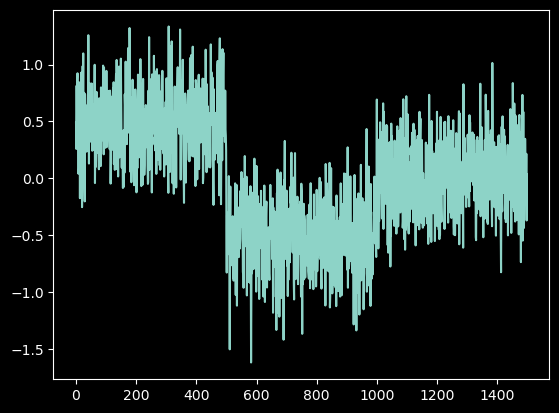

In [151]:
m = 0.5
v = 0.1
n = 500
x1 = np.random.normal(m, np.sqrt(v), n)
m = -0.5
x2 = np.random.normal(m, np.sqrt(v), n)

m = 0
x3 = np.random.normal(m, np.sqrt(v), n)

x = np.hstack((x1,x2,x3))
plt.plot(x)
plt.show()

switched:  50
switched:  105


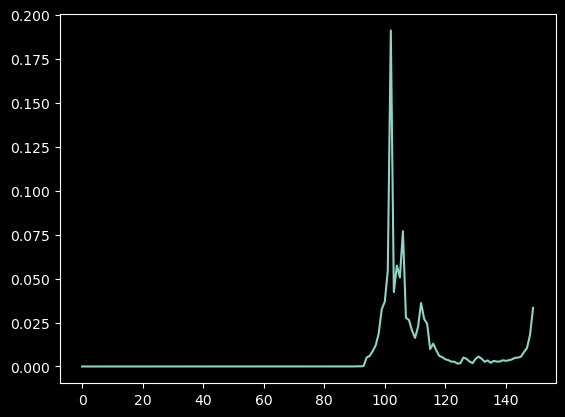

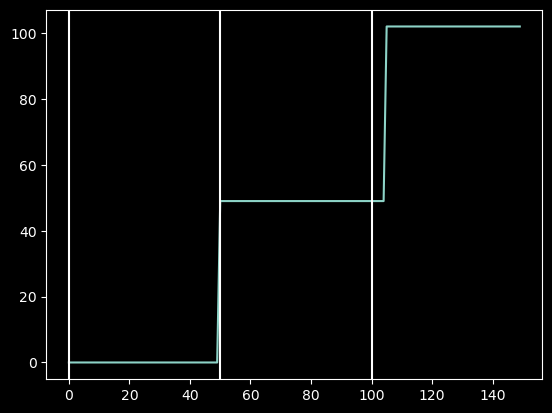

In [147]:
H = 1/30


rl = np.ones(1)
max_rl = np.zeros(x.size)

for i in range(1,x.size):
    # print(i)
    obs = x[i]
    prev_x = x[:i]
    pis = np.ones(prev_x.size)
    for j in range(prev_x.size):
        m = BG()
        m = m.posterior(prev_x[-j-1:])
        pis[j] = m.posterior_predictive_prob(obs)
    pis = pis[::-1]
    new_rl = np.zeros(rl.size + 1)
    new_rl[:rl.size] = rl * pis * (1 - H)
    new_rl[-1] = np.sum(rl * pis * H)
    new_rl /= np.sum(new_rl)
    max_rl[i] = np.argmax(new_rl)
    if max_rl[i]!=max_rl[i-1]:
        print('switched: ', i)
    #print('rl: ', rl)
    #print('new_rl: ', new_rl)
    #print()
    
    rl = new_rl
    #print('-------')
plt.plot(rl)
plt.show()

plt.plot(max_rl)
c = 0
while c<max_rl.size:
    plt.axvline(c)
    c += n
plt.show()

switched:  1
switched:  501
switched:  1003
switched:  1005
switched:  1013


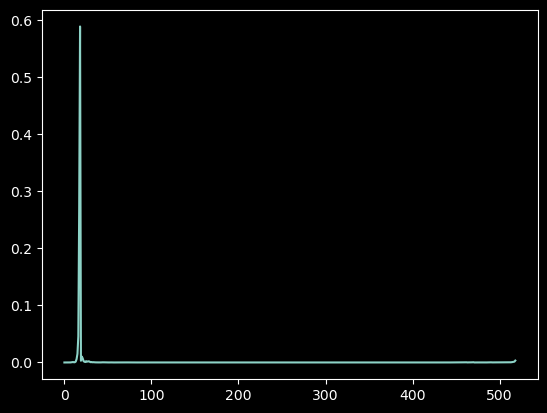

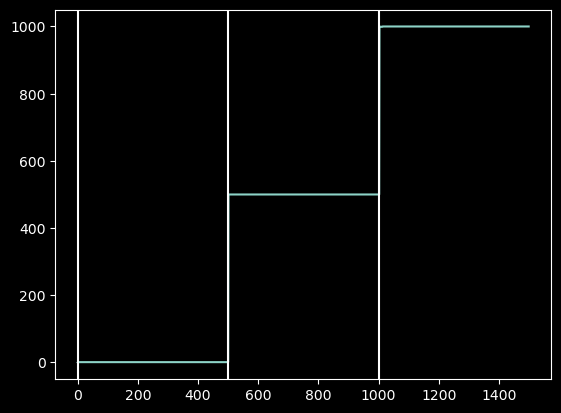

In [152]:
# this is the final version!

H = 1/300

tol = 1e-10
max_size = 500
rl = np.ones(1)
rl_pos = np.ones(1)
max_rl = np.zeros(x.size)
models = [BG()]
# initialize
models[0].update(x[0]) #= models[0].posterior(x[0])

for i in range(1,x.size):
    # print(i)
    obs = x[i]

    pis_models = np.array([m.posterior_predictive_prob(obs) for m in models])    
    
    models.append(BG())
    for m in models: m.update(obs)

    pis = pis_models# pis[::-1]
    new_rl = np.zeros(rl.size + 1)
    rl_pos = np.hstack((rl_pos,[rl_pos[-1]+1]))
    new_rl[:rl.size] = rl * pis * (1 - H)
    new_rl[-1] = np.sum(rl * pis * H)
    new_rl /= np.sum(new_rl)
    
    # filter rl by probability
    #if new_rl.size > max_size:
    #    new_rl = new_rl[-max_size:]
    #    models = models[-max_size:]
    #    new_rl /= np.sum(new_rl)
    
    aux = np.where(new_rl<tol)[0]
    if aux.size != 0:
        idx_cut = aux[-1]
        new_rl = new_rl[idx_cut:]  
        rl_pos = rl_pos[idx_cut:]
        models = models[idx_cut:]
        new_rl /= np.sum(new_rl)
    #    # print(len(models))
        
    max_rl[i] = rl_pos[np.argmax(new_rl)]
    if max_rl[i]!=max_rl[i-1]:
        print('switched: ', i)
    #print('rl: ', rl)
    #print('new_rl: ', new_rl)
    #print()
    
    rl = new_rl
    #print('-------')
plt.plot(rl)
plt.show()

plt.plot(max_rl)

c = 0
while c<max_rl.size:
    plt.axvline(c)
    c += n
plt.show()

In [55]:
m = 1
v = 0.1
n = 100
x = np.random.normal(m, np.sqrt(v), n)

# inference on all data
bg = BG()
bg = bg.posterior(x)
bg.view()

# inference one point at the time
bg = BG()
for i in range(x.size):
    bg = bg.posterior(x[i])
bg.view()


** BG **
<mean> =  0.9077421182864386
<variance> =  0.11088039534769428
** BG **
<mean> =  0.9077421182864386
<variance> =  0.11088039534769432


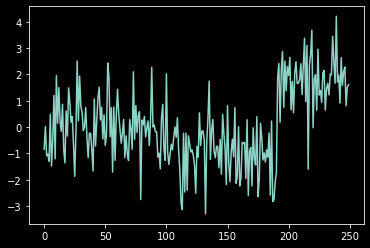

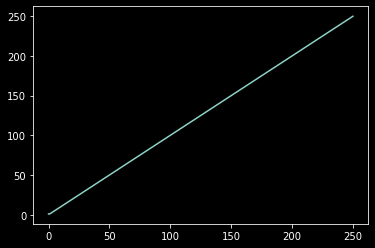

In [192]:
from   scipy.stats import norm
def OnlineBayesForward(x: np.ndarray, model_cls, H:float = 1/60.):
    
    assert x.ndim == 1, "x must be a vector"
    
    models = [model_cls()]    
    
    n = x.size
    
    R = np.zeros((n + 1, n + 1))
    
    R[0,0] = 1
    
    max_R = np.empty(n + 1)

    max_R[0] = 1
    
    mu0 = 0
    lamb0 = 1
    
    mu_params   = np.array([mu0])
    lamb_params = np.array([lamb0])

    rl_pred = lambda x, mu, lamb: norm.pdf(x, mu, 1/lamb + 1)    
    
    for t in range(1, n + 1): 
        
        data = x[i-1]
        
        # predictive probabilities
        #pis = np.array([m.posterior_predictive_prob(data) for m in models])
        #pis = pis[::-1]
        pis = np.array([rl_pred(data, mu_params[i], lamb_params[i]) for i in range(t)])

        R[t, 1:t+1] = R[t-1, :t] * pis * (1-H)
        R[t, 0]     = sum(R[t-1, :t] * pis * H)
        R[t, :]    /= sum(R[t, :])        
        
        max_R[t] = np.argmax(R[t, :])
        offsets     = np.arange(1, t+1)
        mu_params   = np.append([mu0], (mu_params * offsets + data) / (offsets + 1))
        lamb_params = np.append([lamb0], lamb_params + 1)
    
        # update parameters of models
        #for m in models: m.posterior(data)
        # add new model
        #models.append(model_cls())    
    plt.plot(max_R)
    plt.show()
    

model_cls = BG

# changepoint inference
m = 3
v = 1
n = 100
x = np.random.normal(m, np.sqrt(v), n)
m = -3
x = np.hstack((x,np.random.normal(m, np.sqrt(v), n)))

def generate_data(varx, mean0, var0, T, cp_prob):
    """Generate partitioned data of T observations according to constant
    changepoint probability `cp_prob` with hyperpriors `mean0` and `prec0`.
    """
    data  = []
    cps   = []
    meanx = mean0
    for t in range(0, T):
        if np.random.random() < cp_prob:
            meanx = np.random.normal(mean0, var0)
            cps.append(t)
        data.append(np.random.normal(meanx, varx))
    return data, cps
T      = 250   # Number of observations.
hazard = 1/60  # Constant prior on changepoint probability.
mean0  = 0      # The prior mean on the mean parameter.
var0   = 2      # The prior variance for mean parameter.
varx   = 1      # The known variance of the data.
data, cps      = generate_data(varx, mean0, var0, T, hazard)
data = np.array(data)

plt.plot(data)
plt.show()

OnlineBayesForward(data, model_cls, H = 1/60)    



In [ ]:
def OnlineBayesForward(x: np.ndarray, model_cls, H:float = 1/60.):
    assert x.ndim == 1, "x must be a vector"
    
    alpha = np.array([1], dtype = float)

    models = [model_cls()]

    hazard = 1 / 10

    r = np.zeros(x.size, dtype = int)
    
    n = x.size
    
    R = np.zeros((n, n))
    R[0,0] = 1
    
    
    
    for i in range(1, n):
        assert alpha.size == len(models), "models and alpha do not match"
        #print('--------')
        #print(i)
        # t = i + 1    
        # build transition matrix    
        t = alpha.size 
        A_right = np.eye(t) * (1 - hazard)
        # A_center = np.zeros((t,1))
        A_left = hazard * np.ones((t,1))
        A = np.hstack((A_left, A_right))
        # predictive probabilities
        prob = np.array([m.posterior_predictive_prob(x[i]) for m in models])
        # reverse order because new model is appended in the end
        prob = prob[::-1]
        # compute posterior of run lenght
        alpha = np.dot(A.T, alpha * prob)
        # normalize
        alpha /= np.sum(alpha)

        r[i] = i - np.argmax(alpha) + 1
        # update parameters of models
        for m in models: m.posterior(x[i])
        # add new model
        models.append(model_cls())    
    print(r)  
